In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output, display

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2

from os import path
from wordcloud import WordCloud
from PIL import Image


from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from xgboost.sklearn import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight


In [38]:
drexler_df = pd.read_csv('data/drexler_complete_lyrics.csv', sep=';')
drexler_df.sample(10)

,id,lyrics,title,url,album,duplicated,year
65,1508031,"Nada se pierde, nada se vuelve nada Todo te vu...",Nada menos,https://genius.com/Jorge-drexler-nada-menos-ly...,Sea,False,2001
104,1564353,En tu propia fuente llorará la luna Con lágrim...,Toque de Queda,https://genius.com/Jorge-drexler-toque-de-qued...,Amar la trama,False,2010
85,1340418,"Todas las horas, todos los besos Cada recuerdo...",El Fuego Y El Combustible,https://genius.com/Jorge-drexler-el-fuego-y-el...,12 Segundos de Oscuridad,False,2006
121,3204468,Ponemos nota sobre nota Palabra sobre palabra ...,Abracadabras,https://genius.com/Jorge-drexler-abracadabras-...,Salvavidas de hielo,False,2017
113,1949045,Yo miraba la luna de Rasquí Tumbado en la aren...,La Luna de Rasquí,https://genius.com/Jorge-drexler-la-luna-de-ra...,Bailar en la cueva,False,2014
128,3204474,Te salgo a buscar quimera Mariposa de papel T...,Quimera,https://genius.com/Jorge-drexler-quimera-lyrics,Salvavidas de hielo,False,2017
44,1250056,Con mi amor yo quiero bailar Murga Reggae Con ...,Murga reggae,https://genius.com/Jorge-drexler-murga-reggae-...,Llueve,False,1997
82,1719443,Clavo mi remo en el agua Llevo tu remo en el m...,Al Otro Lado del Río,https://genius.com/Jorge-drexler-al-otro-lado-...,Others,False,2005
66,1176108,"Busca mis ojos Toma mi mano, acércate Este es ...",Raquel,https://genius.com/Jorge-drexler-raquel-lyrics,Sea,False,2001
107,2223097,Entrar en este verso como el viento Que mueve ...,Que el soneto nos tome por sorpresa,https://genius.com/Jorge-drexler-que-el-soneto...,Others,False,2010


In [39]:
drexler_df = drexler_df[~drexler_df['duplicated']]
drexler_df = drexler_df.drop(['url', 'duplicated', 'album', 'year', 'id'], axis=1)
drexler_df['artist'] = 'Jorge Drexler'

In [40]:
drexler_df.head()

,lyrics,title,artist
0,El perfume de la sal Del cabo Santa María Reco...,Bienvenida,Jorge Drexler
1,Nos delata el equipaje Y la duda al caminar Su...,Equipaje,Jorge Drexler
2,Se va la tarde en Zanja Honda La playa es brum...,La aparecida,Jorge Drexler
3,"Mabel, dejó El bolso con unas amigas Y salió a...",La luna de espejos,Jorge Drexler
4,Luna del Cabo Boca de túnel Lunar plateado Sob...,La luna del cabo,Jorge Drexler


In [41]:
related_df = pd.read_csv('data/related_lyrics.csv', sep=';')
related_df.sample(10)

,artist,title,lyrics
1356,Silvio Rodríguez,Después que canta el hombre,"Después que canta, el hombre queda solo Solo..."
2518,Lisandro Aristimuño,Rocío,De tu cuerpo cae Agua que moja el día Y no d...
204,Pedro Guerra,Marido De LA Peluquera,De niño bailaba canciones del moro El baile ...
896,Ismael Serrano,Preguntas,Maldigo y preguntas Por qué frunzo el ceño P...
1165,Mercedes Sosa,María va,"Mirar rasgado, patitas chuecas, María va Pis..."
728,Pedro Aznar,Kamikaze,Cayó por fin El noble kamikaze Su piel ardió...
2,Kevin Johansen,"Alta, fea y linda","Era alta, fea y linda Todo en contra y todo ..."
1978,Luis Eduardo Aute,"Ay de ti, ay de mí",Y yo que estaba de vuelta De todas las idas ...
993,Mercedes Sosa,Barco quieto,"Barco quieto No te vayas, te lo pido De est..."
804,Ismael Serrano,Amores Imposibles,"Cuando caiga la tarde, lo verás salir Arrast..."


In [42]:
df = pd.concat([drexler_df, related_df]).reset_index(drop=True)
print(df.shape)
df.head()

(3084, 3)


,artist,lyrics,title
0,Jorge Drexler,El perfume de la sal Del cabo Santa María Reco...,Bienvenida
1,Jorge Drexler,Nos delata el equipaje Y la duda al caminar Su...,Equipaje
2,Jorge Drexler,Se va la tarde en Zanja Honda La playa es brum...,La aparecida
3,Jorge Drexler,"Mabel, dejó El bolso con unas amigas Y salió a...",La luna de espejos
4,Jorge Drexler,Luna del Cabo Boca de túnel Lunar plateado Sob...,La luna del cabo


In [43]:
df.nunique()

artist      21
lyrics    2997
title     2997
dtype: int64

In [76]:
def plot_artist_distribution(df):
    plt.figure(figsize=(15,10))
    values = df['artist'].value_counts()
    order = values.index
    ax = sns.countplot(data=df, x='artist', order=order);
    plt.xticks(rotation=90)
    for p, label in zip(ax.patches, values):
        ax.annotate(label, (p.get_x()+0.2, p.get_height()+0.35))
    sns.despine()

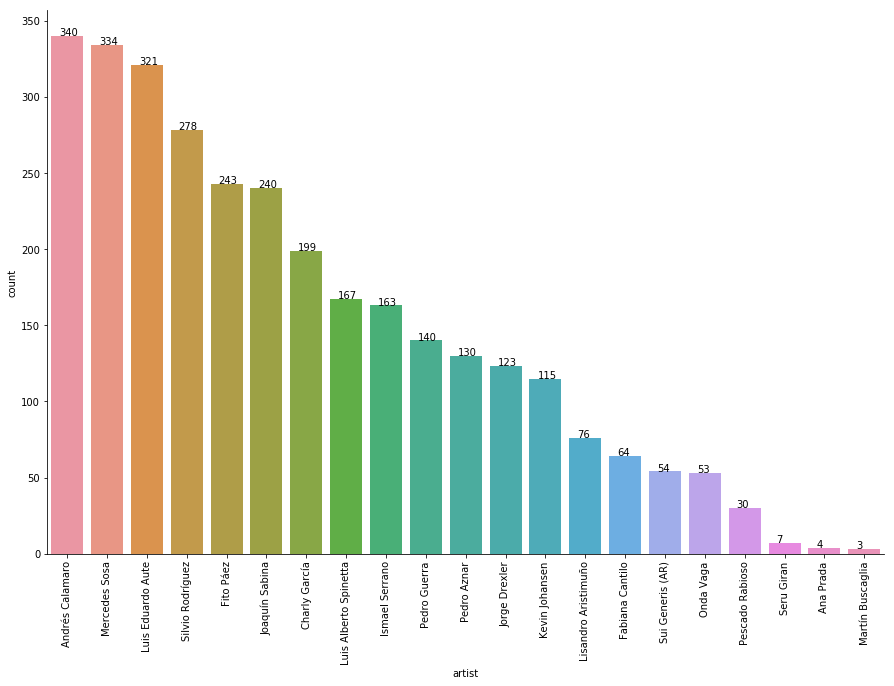

In [45]:
plot_artist_distribution(df)

In [46]:
minority_classes = df[(df['artist'] == 'Seru Giran') | (df['artist'] == 'Ana Prada') | (df['artist'] == 'Martín Buscaglia')]
minority_classes

,artist,lyrics,title
1081,Martín Buscaglia,Cerebro cerebro gracias por estar En cabeza ...,Cerebro orgasmo envidia & sofia
1082,Martín Buscaglia,"Recuerdo aquella noche, soñé que estaba muer...",Jim beam dream
1083,Martín Buscaglia,Que importa saber quién soy Ni de dónde veng...,Vagabundo
1084,Ana Prada,Tuve que cerrar los ojos y dejarte ir Tuve q...,Adiós
1085,Ana Prada,Sur de la orilla de acá De mi río que corta ...,Amargo de caña
1086,Ana Prada,Una vuelta y otra vuelta Como el rio parana ...,Camalotes sueltos
1087,Ana Prada,Soy pecadora... Los santitos huyen de mi age...,Soy pecadora
2684,Seru Giran,A simple vista puedes ver Como borrachos en ...,A los jóvenes de ayer
2685,Seru Giran,"Quién sabe, <a annotation-fragment=""8352909""...",Canción de Alicia en el País
2686,Seru Giran,Serú Girán Miscellaneous Peperina Quiero con...,Peperina


In [47]:
df = df.drop(minority_classes.index)

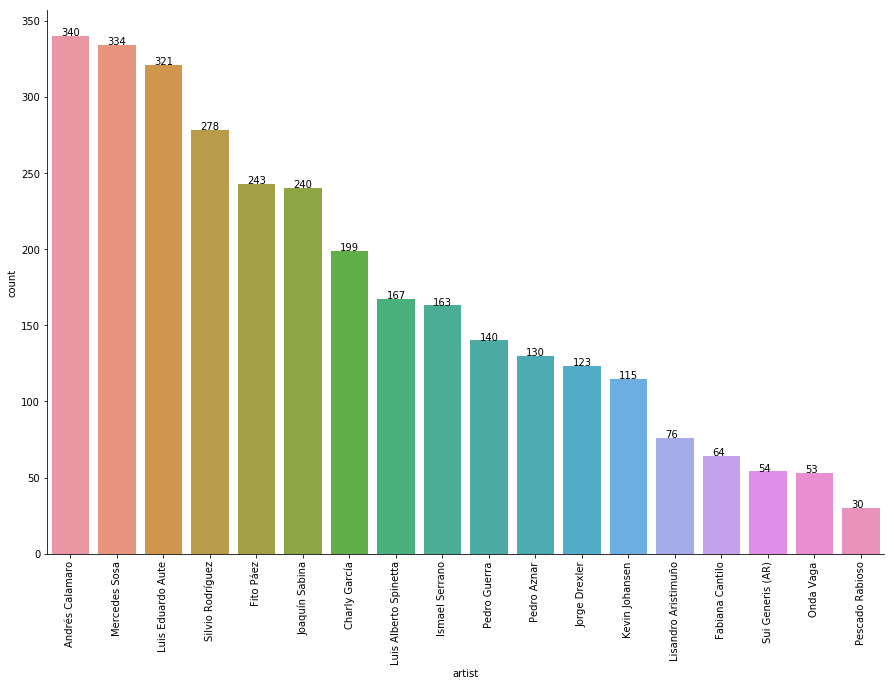

In [48]:
plot_artist_distribution(df)

In [49]:
trash_collected = set(['gégé', 'lalala', 'na', 'ke', 'shh', 'hey', 'wadu', 'vos', 'uh', 'lala', 'ah', 'oh'])
english_stopwords = set(stopwords.words('english'))
stop_words = set(stopwords.words('spanish')).union(trash_collected).union(english_stopwords)

In [50]:
df['artist_id'] = df['artist'].factorize()[0]
artist_id_df = df[['artist', 'artist_id']].drop_duplicates().sort_values('artist_id')
artist_to_id = dict(artist_id_df.values)
id_to_artist = dict(artist_id_df[['artist_id', 'artist']].values)

In [51]:
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(df.lyrics).toarray()
labels = df.artist_id
features.shape

(3070, 201883)

In [52]:
N = 10
words_by_artist = {}
for artist, artist_id in sorted(artist_to_id.items()):
    features_chi2 = chi2(features, labels == artist_id)
    indices = np.argsort(features_chi2[0])
    weights = np.sort(features_chi2[0])[::-1]
    feature_names = np.array(tfidf.get_feature_names())[indices]
    feature_by_weight = list(zip(feature_names,weights))[-N*2:]
    words_by_artist[artist] = feature_by_weight
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(artist))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Andrés Calamaro':
  . Most correlated unigrams:
. zorro
. lloren
. cualquiera
. pusiste
. empezar
. calamaro
. núnca
. primero
. varón
. problemas
  . Most correlated bigrams:
. toda fuerza
. adentro siempre
. quedar adentro
. quiero solo
. mejor así
. quiero termine
. pudiera elegir
. elegir sabría
. sabría decir
. gusta si
# 'Charly García':
  . Most correlated unigrams:
. chipi
. fantasy
. desaparecer
. abras
. cambiaste
. rezo
. videotape
. pegando
. pasajera
. asesíname
  . Most correlated bigrams:
. dudas voy
. siento fuerte
. nadie alrededor
. pueden desaparecer
. aguante aguante
. rezo rezo
. pasajera trance
. amor real
. asesíname asesíname
. gozar tan
# 'Fabiana Cantilo':
  . Most correlated unigrams:
. mintiendo
. arrancar
. busques
. caminándote
. heroe
. profugos
. choca
. divierte
. arrancacorazones
. intoxicarme
  . Most correlated bigrams:
. robar lejos
. choca pared
. bajo tren
. mirar soles
. pared divierte
. volar irse
. cielos mirar
. lejos cielos
. divierte vola

In [80]:
def plot_wordcloud_from_dict(a_dict, rows, columns):
    fig, axes = plt.subplots(rows,columns, figsize=(30,20))
    axes_ravel = np.ravel(axes)
    # read the mask image
    a_mask = np.array(Image.open("heart.jpg"))

    wc = WordCloud(background_color="white", max_words=1000, mask=a_mask, max_font_size=100, width=800, height=400)
    for i, an_artist in enumerate(a_dict):
        freqs_by_words = {}
        for a_topic_term in a_dict[an_artist]:
            an_actual_word = a_topic_term[0]
            freqs_by_words[an_actual_word] = a_topic_term[1]

        # generate word cloud
        wc.generate_from_frequencies(freqs_by_words)

        #show
        axes_ravel[i].set_title(an_artist)
        axes_ravel[i].imshow(wc, cmap=plt.cm.gray, interpolation='bilinear');
        axes_ravel[i].axis("off")
#         extent = axes_ravel[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#         fig.savefig(an_artist + '.png', bbox_inches=extent)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.4)
    plt.show()

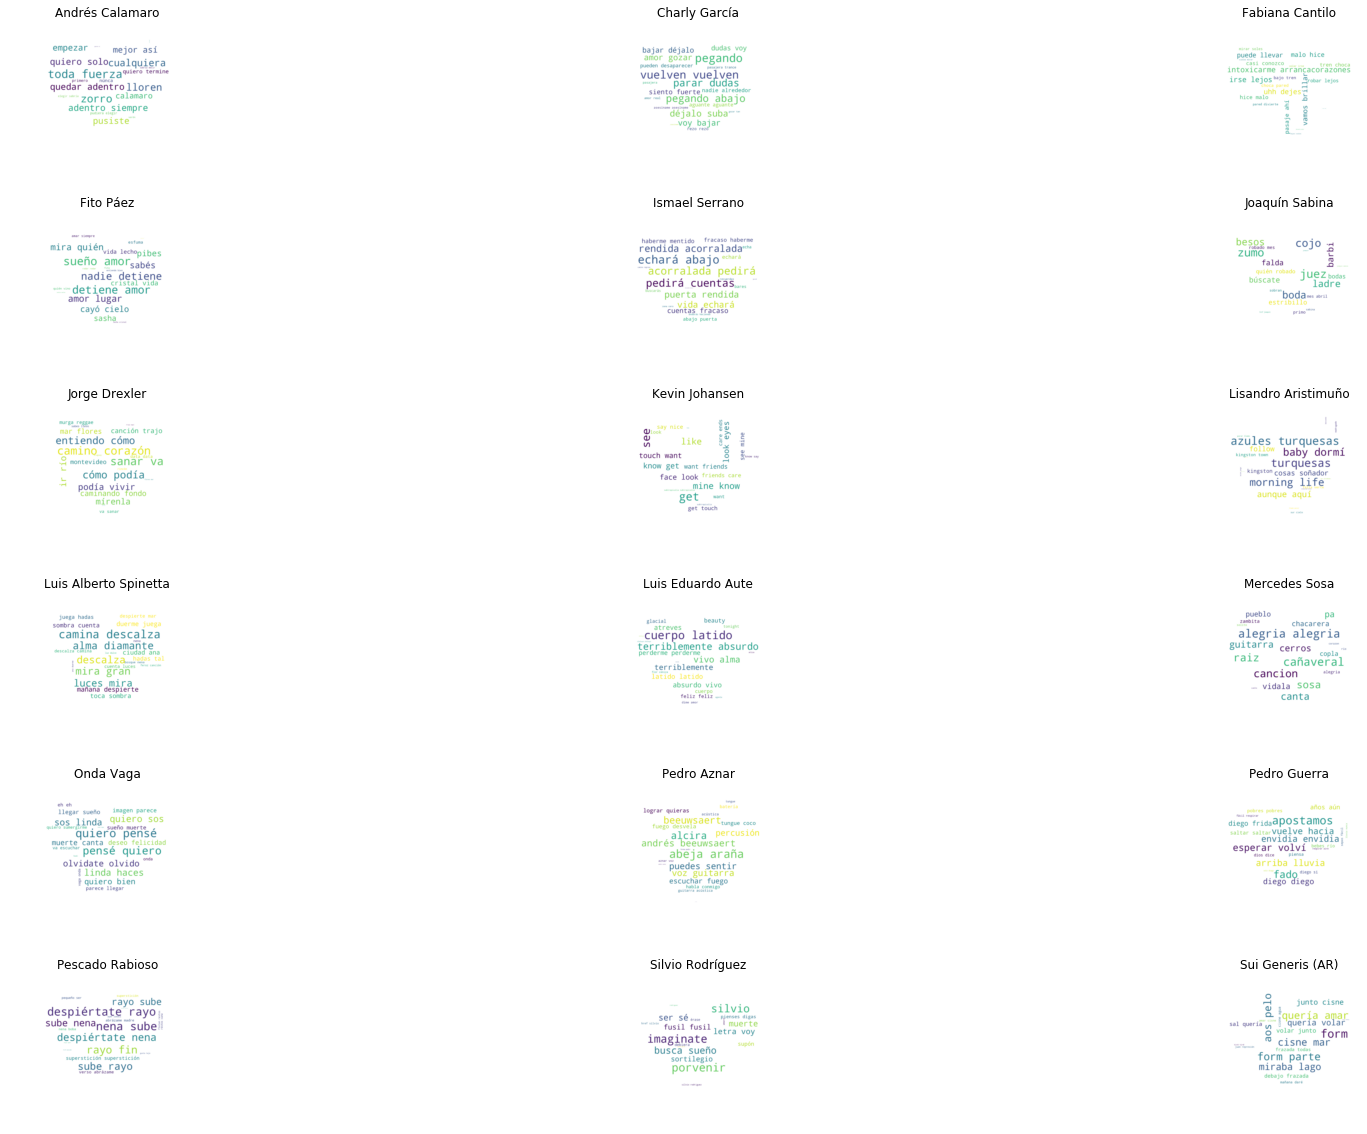

In [54]:
plot_wordcloud_from_dict(words_by_artist, 6, 3)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['artist'], test_size=0.33, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [56]:
models = [
    RandomForestClassifier(class_weight='balanced'),
    LinearSVC(class_weight='balanced'),
    MultinomialNB(),
    LogisticRegression(class_weight='balanced',random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        print(fold_idx, accuracy)
    print("%s processed" % model_name)
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
0 0.277867528271
1 0.285251215559
2 0.297077922078
3 0.281505728314
4 0.2784184514
RandomForestClassifier processed
LinearSVC
0 0.563812600969
1 0.539708265802
2 0.587662337662
3 0.572831423895
4 0.561779242175
LinearSVC processed
MultinomialNB
0 0.29886914378
1 0.26904376013
2 0.269480519481
3 0.270049099836
4 0.260296540362
MultinomialNB processed
LogisticRegression
0 0.53957996769
1 0.518638573744
2 0.550324675325
3 0.538461538462
4 0.533772652389
LogisticRegression processed


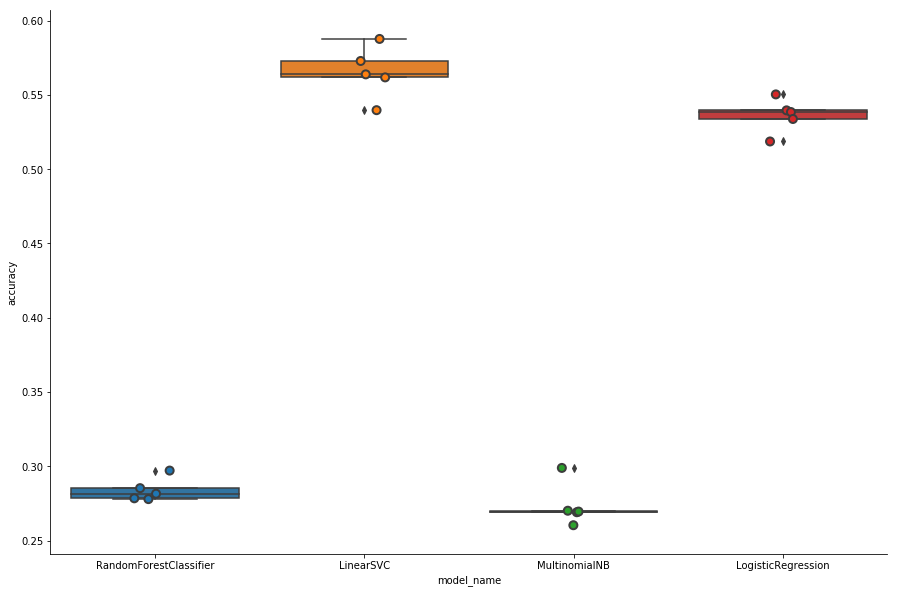

In [57]:
plt.figure(figsize=(15,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df);
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2);
sns.despine()
plt.show()

In [58]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.565159
LogisticRegression        0.536155
MultinomialNB             0.273548
RandomForestClassifier    0.284024
Name: accuracy, dtype: float64

In [59]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

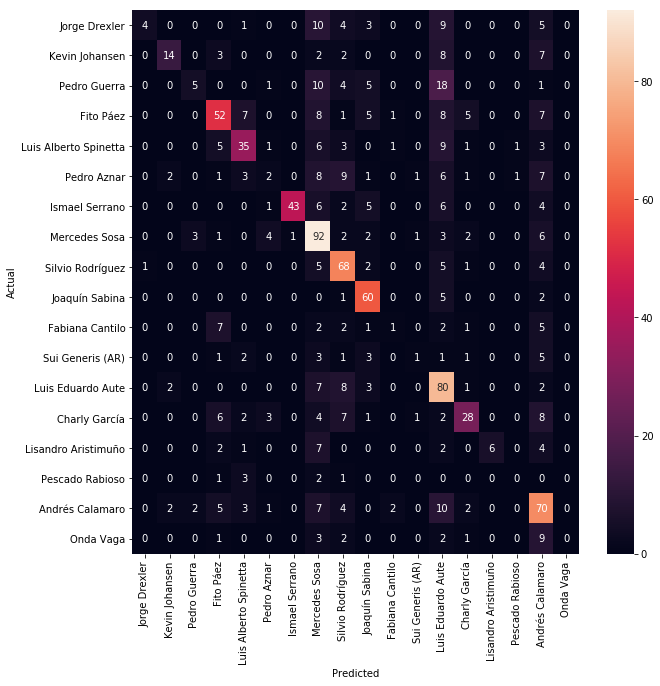

In [60]:
svm = LinearSVC(class_weight='balanced')
model = OneVsRestClassifier(svm) 

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred, labels=labels.unique())
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=artist_id_df.artist.values, yticklabels=artist_id_df.artist.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Mal desempeño, mucho ruido. Lets narrow it down

In [62]:
df.artist.unique()

array(['Jorge Drexler', 'Kevin Johansen', 'Pedro Guerra', 'Fito Páez',
       'Luis Alberto Spinetta', 'Pedro Aznar', 'Ismael Serrano',
       'Mercedes Sosa', 'Silvio Rodríguez', 'Joaquín Sabina',
       'Fabiana Cantilo', 'Sui Generis (AR)', 'Luis Eduardo Aute',
       'Charly García', 'Lisandro Aristimuño', 'Pescado Rabioso',
       'Andrés Calamaro', 'Onda Vaga'], dtype=object)

In [72]:
artists_chosen = ['Pedro Guerra', 'Fito Páez', 'Luis Alberto Spinetta', 'Jorge Drexler']

In [75]:
narrow_df = df[df.artist.isin(artists_chosen)]

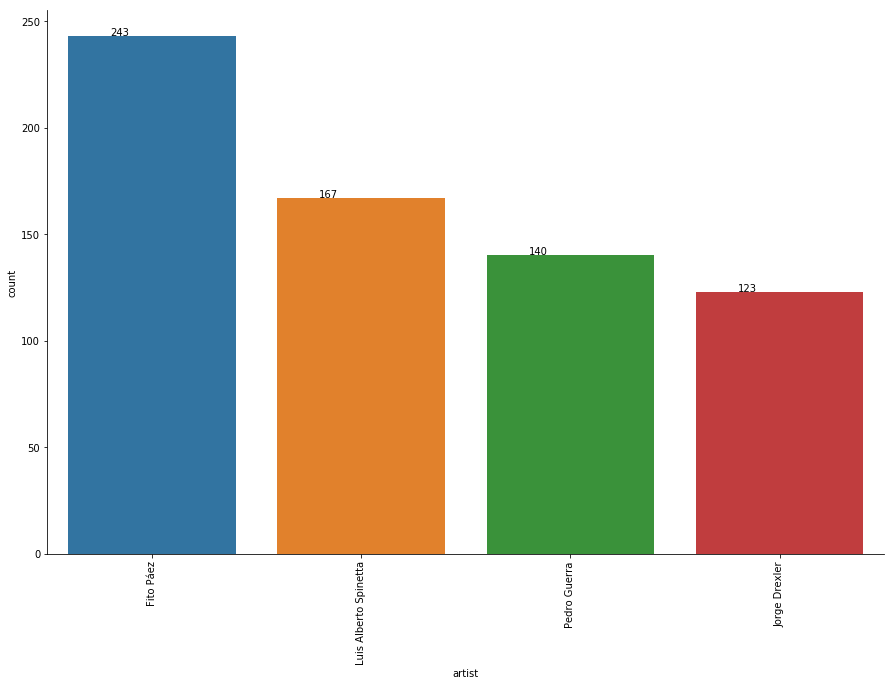

In [77]:
plot_artist_distribution(narrow_df)

In [78]:
narrow_df['artist_id'] = narrow_df['artist'].factorize()[0]
artist_id_df = narrow_df[['artist', 'artist_id']].drop_duplicates().sort_values('artist_id')
artist_to_id = dict(artist_id_df.values)
id_to_artist = dict(artist_id_df[['artist_id', 'artist']].values)
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(narrow_df.lyrics).toarray()
labels = narrow_df.artist_id
features.shape

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(673, 51037)

In [79]:
N = 10
words_by_artist = {}
for artist, artist_id in sorted(artist_to_id.items()):
    features_chi2 = chi2(features, labels == artist_id)
    indices = np.argsort(features_chi2[0])
    weights = np.sort(features_chi2[0])[::-1]
    feature_names = np.array(tfidf.get_feature_names())[indices]
    feature_by_weight = list(zip(feature_names,weights))[-N*2:]
    words_by_artist[artist] = feature_by_weight
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(artist))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Fito Páez':
  . Most correlated unigrams:
. ahí
. mamá
. habana
. ciudad
. amp
. voy
. bar
. sos
. roll
. rock
  . Most correlated bigrams:
. tocar rock
. rock amp
. amp roll
. lecho cristal
. pasó pasó
. corazón corazón
. vueltas vueltas
. voy olvidar
. buenos aires
. rock roll
# 'Jorge Drexler':
  . Most correlated unigrams:
. apenas
. cruzando
. carbón
. cerrar
. supe
. pelo
. propia
. estela
. rincón
. girando
  . Most correlated bigrams:
. mar flores
. va sanar
. camino mar
. ser eterno
. flores mar
. vida entera
. trajo aquí
. bien haces
. haces bien
. río abajo
# 'Luis Alberto Spinetta':
  . Most correlated unigrams:
. fin
. nena
. descalza
. despertar
. brisa
. solo
. así
. dirá
. oye
. acaso
  . Most correlated bigrams:
. nunca encontrarás
. vez mañana
. bosque nena
. feroz canción
. mas allá
. luz dulce
. ana duerme
. vez solo
. solo quiero
. si acaso
# 'Pedro Guerra':
  . Most correlated unigrams:
. bailan
. verdes
. cariño
. pa
. trigo
. vela
. huesos
. raíz
. diego
. pi

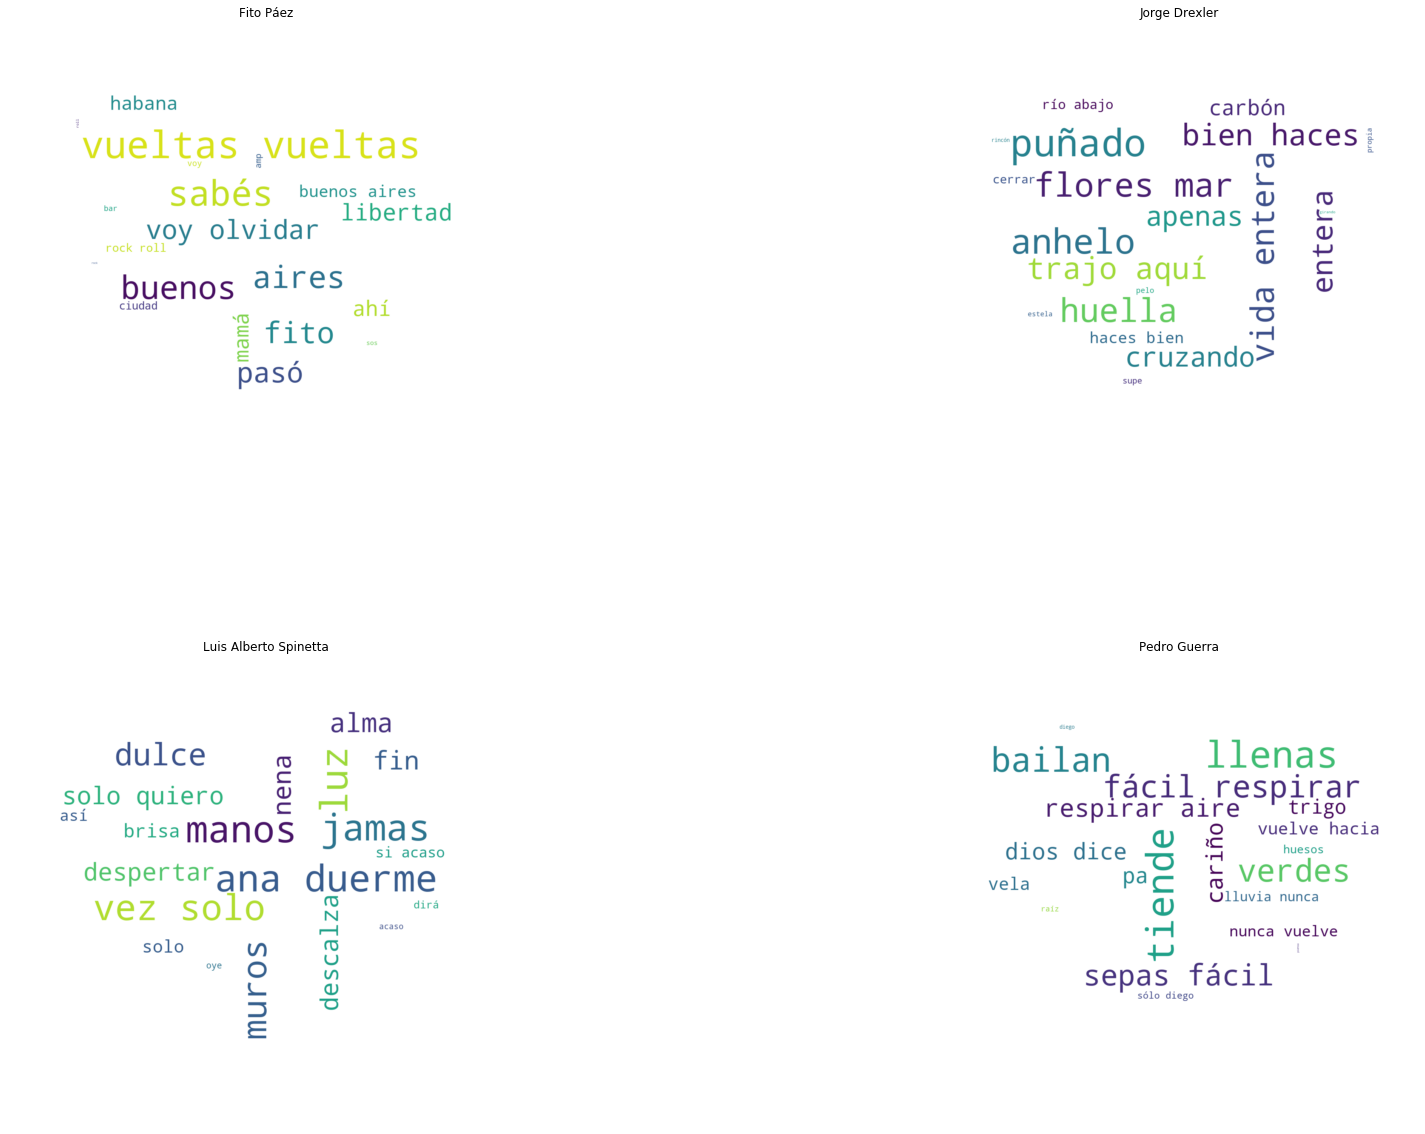

In [81]:
plot_wordcloud_from_dict(words_by_artist, 2, 2)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(narrow_df['lyrics'], narrow_df['artist'], test_size=0.33, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [
    RandomForestClassifier(class_weight='balanced'),
    LinearSVC(class_weight='balanced'),
    MultinomialNB(),
    LogisticRegression(class_weight='balanced',random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        print(fold_idx, accuracy)
    print("%s processed" % model_name)
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
0 0.492647058824
1 0.544117647059
2 0.540740740741
3 0.458646616541
4 0.533834586466
RandomForestClassifier processed
LinearSVC
0 0.713235294118
1 0.617647058824
2 0.725925925926
3 0.691729323308
4 0.759398496241
LinearSVC processed
MultinomialNB
0 0.367647058824
1 0.375
2 0.377777777778
3 0.360902255639
4 0.360902255639
MultinomialNB processed
LogisticRegression
0 0.566176470588
1 0.522058823529
2 0.540740740741
3 0.526315789474
4 0.526315789474
LogisticRegression processed


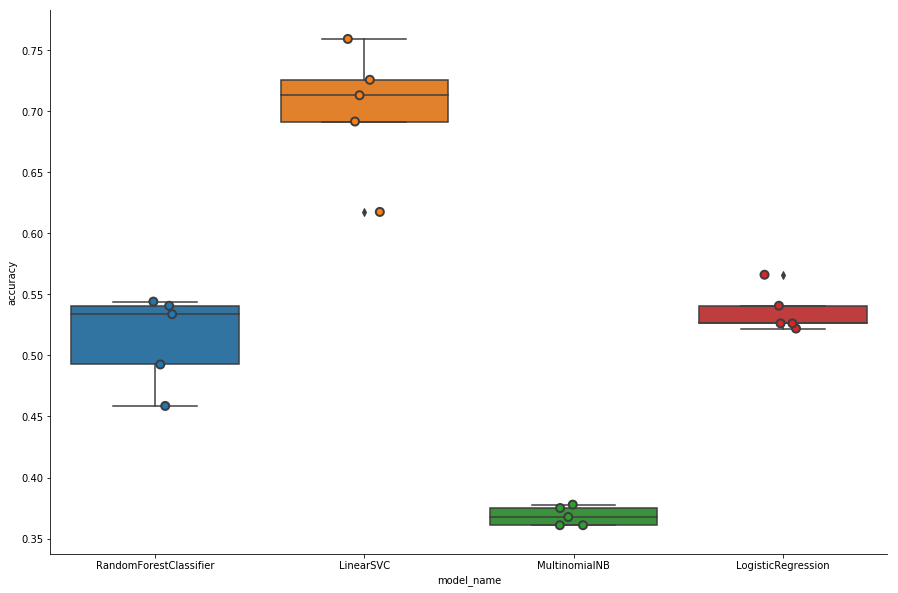

In [89]:
plt.figure(figsize=(15,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df);
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2);
sns.despine()
plt.show()

In [90]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.701587
LogisticRegression        0.536322
MultinomialNB             0.368446
RandomForestClassifier    0.513997
Name: accuracy, dtype: float64

In [91]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

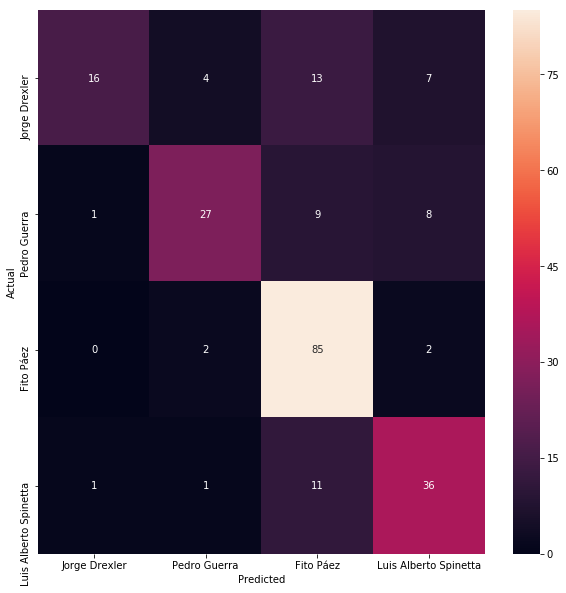

In [92]:
svm = LinearSVC(class_weight='balanced')
model = OneVsRestClassifier(svm) 

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, narrow_df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred, labels=labels.unique())
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=artist_id_df.artist.values, yticklabels=artist_id_df.artist.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [95]:
pd.set_option('display.max_colwidth', -1)
for predicted in artist_id_df.artist_id:
    for actual in artist_id_df.artist_id:
        if predicted != actual and conf_mat[actual, predicted] >= 3:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_artist[actual], id_to_artist[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['artist', 'lyrics']])
            print('')

'Jorge Drexler' predicted as 'Pedro Guerra' : 4 examples.


,artist,lyrics
68,Jorge Drexler,"Vale Una vida lo que un sol Una vida lo que un sol Vale Se aprende en la cuna Se aprende en la cama Se aprende en la puerta de un hospital Se aprende de golpe Se aprende de a poco y a veces se aprende recién al final Toda la gloria es nada Toda vida es sagrada Una estrellita de nada En la periferia De una galaxia menor Una, entre tantos millones Y un grano de polvo girando a su alrededor No dejaremos huella Sólo polvo de estrellas Vale Una vida lo que un sol Una vida lo que un sol Vale Se aprende en la escuela Se olvida en la guerra Un hijo te vuelve a enseñar Está en el espejo Está en las trincheras, parece que nadie parece notar Toda victoria es nada Toda vida es sagrada Un enjambre de moléculas Puestas de acuerdo De forma provisional Un animal prodigioso Con la delirante obsesión de querer perdurar No dejaremos huella Sólo polvo de estrellas"
1,Jorge Drexler,Nos delata el equipaje Y la duda al caminar Su prudencia pueblerina Mi silencio en catalán La niebla de Barcelona Cómo un púdico tapiz Y allá vamos soñolientos Tras la sombra de Gaüdí Poco importan las versiones Los resabios de un lugar Las postales consabidas La edad de una catedral La caricia minuciosa De los siglos de humedad Y las gárgolas que te miran Sobrevuelan la ciudad Los mojones del camino Con su ambigua cicatriz Van marcando el fuselaje Descascarando el barniz La distancia es un Oasis Una forma de mentir Visitamos los museos Codiciando souvenirs
77,Jorge Drexler,"El deseo sigue un curso paralelo Y la historia es una red y no una vía Días y noches de amor y de celos Una cama se llena y otra se vacía Yo lo vi, hasta en los hospitales Escapándose al motel los cirujanos... ¡Tan complicados los simples mortales Y tan fácil saber que se traen entre manos! Y bajo los congresos, las giras, rodajes Las ferias agrícolas y convenciones Gira inexorable el otro engranaje La noria invisible de las transgresiones La vida también es aquellos mensajes Aquella llamada hecha desde la esquina Poco de negocio tenían los viajes Todo de su amor, aquella oficina El cantante ávido de nuevas pieles... Aquel literato lució su guiñada... Y por los pasillos de tantos hoteles El tráfico arrecia en las madrugadas Clara, evidente, manda la libido La fidelidad, brumosa palabra Con su antigua lista de gestos prohibidos Muerde siempre menos de lo que ladra"
101,Jorge Drexler,"Todo cambia de bolsillo Sin el mínimo decoro El oro es lo que importa En el becerro de oro Todos quieren todo Todo siempre es poco La lente que todo lo mira Ya no hace foco Y siga el baile hasta que aclare Busquemos el penúltimo atún Por los siete mares Y nadie existe si no es noticia La codicia del glamour Y el glamour de la codicia Data, data, data, data, data, data, data Cómo se bebe de una catarata Data, data, data, data, data, data, data Cómo se bebe de una catarata Todo cambia de bolsillo Sin el mínimo decoro El oro es lo que importa En el becerro de oro Todos quieren todo Todo siempre es poco La lente que todo lo mira Ya no hace foco Y siga el baile hasta que aclare Busquemos el penúltimo atún Por los siete mares Y nadie existe si no es noticia La codicia del glamour Y el glamour de la codicia Data, data, data, data, data, data, data Cómo se bebe de una catarata Data, data, data, data, data, data, data Cómo se bebe de una catarata"



'Jorge Drexler' predicted as 'Fito Páez' : 13 examples.


,artist,lyrics
79,Jorge Drexler,"Quien no lo sepa ya Lo aprenderá de prisa: La vida no para No espera, no avisa Tantos planes, tantos planes Vueltos espuma Tu, por ejemplo Tan a tiempo Y tan Inoportuna Eran más bien los días De arriar las velas Toda señal a mi alrededor Decía: cautela Cuánta estrategia incumplida Aquella noche sin luna Tu, por ejemplo Tan bienvenida Y tan Inoportuna Quien sabe cuándo Cuándo es el momento de decir: ahora Si todo alrededor te está gritando: ¡Sin demora, sin demora!"
48,Jorge Drexler,"Princesa bacana Sexo, marihuana y milongón Ya cuelgo de tu ombligo No juegues conmigo tus juegos de salón… Mueve tu primero Que yo aquí te espero Anticipando el tacto de cada labio de tu beso Princesa haragana ¡que fin de semana! Princesa dormida Yo bajo a por algo de comer Regreso, y princesa Ya ha puesto la mesa: la cama es el mantel… Prueba tu primero Que yo aquí prefiero Mirarte sonreír frente a ese plato de cerezas… Brindemos ,princesa Por esta brutal pereza Es lunes de mañana; Cualquiera se separa De una princesa bacana… Princesa bacana Que fin de semana ¡que fin de semana!"
85,Jorge Drexler,"Dove sei, bella? Dove vai? Donde sera que estas ahora En este instante? En cual de tus varios mundos distantes? Cause you come and you go You go and I wait I wait and you move You move and I come Dove sei, bella? Dove vai? Sera que sientes en la distancia, mi compania? Y en cual de tus varias sillas vacias? Cause you come and you go You go and I wait I wait and you move You move and I come Dove sei, bella? Dove vai? Donde sera que estas ahora En este instante? En cual de tus varios mundos distantes?"
18,Jorge Drexler,Tomé de un trago el veneno De esos ojos de mujer Seguí su canto en las rocas Un descuido y naufragué Y hoy sólo fumo callado Cuando escucho hablar de amor De ese fruto codiciado Yo ya conozco el sabor No vi la red escondida La trampa esperándome Creí sincera su entrega Y por entero me entregué Pero eso fue hace ya mucho Ya aprendí de mi dolor Y hoy sólo fumo y escucho Cuando siento hablar de amor
55,Jorge Drexler,"Para contarte, canto Quiero que sepas cuánto Me haces bien Me haces bien Me haces bien Te quiero de mil modos Te quiero sobre todo Me haces bien Me haces bien Me haces bien Basta ver el reflejo de tus ojos en los míos Como se lleva el frío Para entender Que el corazón no miente Que afortunadamente Me haces bien Me haces bien Me haces bien Para contarte, canto Quiero que sepas cuánto Me haces bien Me haces bien Me haces bien Basta ver el reflejo de tus ojos en los míos Como se lleva el frío Me haces bien Me haces bien Me haces bien Me haces bien Me haces bien Me haces bien Me haces bien Me haces bien"
40,Jorge Drexler,Era el tiempo del cambio El tiempo de la estampida El tiempo de la salida El tiempo de esta canción Era el tiempo de ver El tiempo de otra manera Y yo no sabía que era El tiempo del corazón Era el tiempo De cada cosa a su tiempo En tiempo de bossa O de candombear Por esos tiempos yo andaba Siempre corto de tiempo Y nunca encontraba tiempo En ningún lugar Cabe decir que es tiempo De rememorar Los viejos tiempos Aquella ciudad… Aunque no se más Que para decir Que de tiempo en tiempo Conviene recordar: Que todo tiempo pasado es peor No hay tiempo perdido peor Que el perdido en añorar Era Mayo del 68 Pero en Montevideo del 83 Era el tiempo De la apertura Tiempo de dictaduras Derrumbándose Eran tiempos De revolcones Manifestaciones: Yo empecé a fumar Y cuando fumaba El tiempo pasaba mas lento Y yo me sentaba A verlo pasar A verlo pasar… Cabe decir que es tiempo De rememorar Aquellos tiempos La facultad… Aunque no sea mas Que para saber Que el tiempo no suele Dar marcha atrás Y todo tiempo pasado es peor No hay tiempo perdido peor Que el perdido en añorar
17,Jorge Drexler,"Cuando la noche pasea Más allá de mi pretil Yo puedo ver para afuera Sin que me veas a mí Yo puedo ver la luz Yo puedo ver tu piel Yo puedo ver tu ropa caer Yo puedo adivinar La nube de vapor Que tiene el aire a tu alrededo


'Pedro Guerra' predicted as 'Fito Páez' : 9 examples.


,artist,lyrics
365,Pedro Guerra,"Yo no me dí cuenta de que te tenía Hasta el mismo día en que te perdí Y vi claramente lo que te quería Cuando ya no había remedio pa' mi Llévame por calles de hiel y amargura Pónme ligaduras y hasta escúpeme échame en los ojos un puñao de arena Mátame de pena, pero quiéreme Mira que te llevo dentro de mi corazón Por la salucita de la mare mía te lo juro yo Mira que pa mi en er mundo No hay ná más que tú Y que mi sacais, si digo mentira Se queden sin lú Por ti contaría la arena del mar Por ti yo sería capaz de matar Y que si te miento Me castigue Dios Eso con las manos Sobre el Evangelio Te lo juro yo Ya no eres la misma que yo conocía La que no veía ná más que por mí Que ahora vas con uno distinto cada día Y en cambio yo muero de celos por ti Claro que la culpa de que esto pasara No la tuvo nadie, nadie más que yo Yo que me reía de que esto acabara Y ahora sufro y lloro porque se acabó Mira que te llevo dentro de mi corazón..."
259,Pedro Guerra,"Me acobardó la soledad Y el miedo enorme de morir lejos de tí... ¡Qué ganas tuve de llorar Me acobardó la soledad Y el miedo enorme de morir lejos de tí... ¡Qué ganas tuve de llorar Sintiendo junto a mí La burla de la realidad! Y el corazón me suplicó Que te buscara Y que le diera tu querer... Me lo pedía el corazón Y entonces te busqué Creyéndote mi salvación... Y ahora que estoy frente a ti Parecemos, ya ves, dos extraños... Lección que por fin aprendí: ¡Cómo cambian las cosas los años! Angustia de saber muertas ya La ilusión y la fe... Perdón si me ves lagrimear... ¡Los recuerdos me han hecho mal! Palideció la luz del sol Al escucharte fríamente conversar... Fue tan distinto nuestro amor Y duele comprobar Que todo, todo terminó ¡Qué gran error volverte a ver Para llevarme destrozado el corazón! Son mil fantasmas, al volver Burlándose de mí Las horas de ese muerto ayer..."
317,Pedro Guerra,"Las gafas de Lennon hicieron historia Y algún que otro gesto Que hoy guardo en memoria de un tiempo que fué Un tiempo de flores y buenas noticias Un tiempo de amores y dulces caricias Imagine all the people Y aún esta por ver que no será posible Imagine all the people Y habrá que responder que no será posible Las gafas de Lennon son lunas redondas Tan siempre modernas Tan llenas de historias de un tiempo que fué Un tiempo de luces y buenas canciones Un tiempo de guerras paradas con flores Imagine all the people Y aún esta por ver que no será posible Imagine all the people Y habrá que responder que no será posible Vivimos el tiempo que alcabo nos toca Salimos al paso gastamos las botas de un tiempo que es No es bueno quedarse colgados de un sueño Habra que empujarlo, llegado el momento Imagine all the people Y aún esta por ver que no será posible Imagine all the people Y habrá que responder que no será posible Imagine all the people Y aún esta por ver que no será posible Imagine all the people Y habrá que responder que si será posible"
337,Pedro Guerra,"Quiero emborrachar mi corazón Para apagar un loco amor Que más que amor es un sufrir... Y aquí vengo para eso A borrar antiguos besos En los besos de otras bocas Si su amor fue flor de un día Por que causa es siempre mía Esta cruel preocupación Quiero, por los dos, mi copa alzar Para olvidar mi obstinación Y más la vuelvo a recordar Nostalgias De escuchar su risa loca Y sentir junto a mi boca Como fuego su respiración... Angustias De sentirme abandonado Y pensar que otro a su lado Pronto, pronto le hablara de amor... Hermano Yo no quiero rebajarme Ni pedirle ni rogarle Ni decirle que no puedo más vivir Desde mi triste soledad Veré caer las rosas muertas De mi juventud Gime, bandoneón, tu tango gris Quizás a ti te hiera igual Algún amor sentimental... Llora mi alma de fantoche Sola y triste en esta noche Noche negra y sin estrellas Si las copas traen consuelo Aquí estoy con mi desvelo Para ahogarlo de una vez Quiero emborrachar al corazón Para después poder brindar Por los fracasos del amor Nostalgias..."
255,Pedro Gu


'Luis Alberto Spinetta' predicted as 'Fito Páez' : 11 examples.


,artist,lyrics
747,Luis Alberto Spinetta,"No voy a hablar de la penumbra Mejor voy a ver si puedo despertar No quiero hablar de tantas cosas Mejor voy a ver si puedo olvidar Mientras se viaja Hacia la sal, no entiendo ya Si es bien o mal Y tengo frío en la penumbra Mientras tu vienes hacia mi Yo ya no entiendo Si es así vivir y tengo frío En la penumbra, di, da, da... Mi alma es un muro Que ya no canta Mejor sigo así Tratando de mirar No quiero hablar De tantas cosas Mejor voy a ver Si puedo descansar Mientras se viaja Hacia la sal, no entiendo ya Si es bien o mal Y tengo sed en la penumbra Y tu te acercas hacia mi Yo ya no entiendo Si es así vivir y tengo sed En la penumbra oh Da, da, da"
718,Luis Alberto Spinetta,Laura va Lentamente guarda en su valija gris el final De toda una vida de penas... Laura ve Unos pasos la alejan del pueblo aquel donde ayer Jugaba al salir de las escuela... Laura pobre tu dolor Se cayó de una oración Por eso te vas con él Por eso te vas... Y hay algo de bueno en tus ojos sin querer Laura va Los años le han dado la resignación y el dolor Se fue con sus pocas tibiezas... Laura ve Aunque es grande su vida comienza aqui y a la vez Termina la sed de su espera... Laura pobre tu dolor Se cayó de una oración Por eso te vas con él Por eso te vas... Y hay algo de bueno en tus ojos sin querer La valija pesa Y él le ayuda a entrar en el tren La cubre de besos y el sol tambien
737,Luis Alberto Spinetta,"Algo esta pasando hoy Es que te quiero tanto amor Ya nada esta cerrado Luce como el mundo de hoy Me estaba preguntando Me estaba preguntando Estaba simplemente asi Super bien Y ellos se estaban oxidando Y yo estaba por creer en vos No te alejes tanto amor No te alejes tanto de mi Me estaba preguntando Y estaba alimentado Y estaba alucinando bien Super super Y es que estaba satinado Y estaba por pensar en vos En vos Y estaba yo pensando Que era balanceado Que estabas acercandote, nena Vos acercandote Y no, vos venias por alta Yo estaba satinado Me estabas recurriendo al fin Nena, al fin, si AH... No te alejes tanto de mi Ah... No te alejes tanto de mi..."
660,Luis Alberto Spinetta,"Tienes un poder mejor Tienes un nuevo reloj Ya no tienes cuenta en el sol Tienes un mejor lugar Tienes un mejor dormir Ya no tienes cuenta en el sol, no Es este mundo de locos y fascistas Dime nena como puedo yo cambiarlo Puedes mejorar la luz Puedes mejorar la cruz Ya no te interesa ayudar, ni ahí Puedes mejorar el lifting Aunque puedes mendigar Lo que tienes es petróleo en el mar, ah Es este mundo de locos y fascistas Dime nena como puedo yo cambiarlo ""Vamos Luigi!... Sí...!"" ""cuidado con el bobero nena"" Tienes un lugar mejor Tienes un mejor dormir Ya no tienes la cuenta en el sol Puedes mejorar el lifting Aunque puedes mendigar Lo que tienes es petróleo en el mar (hasta las Orejas) Es este mundo de locos y fascistas Dime nena como puedo yo, ufa! cambiarlo Vamos!"
649,Luis Alberto Spinetta,"Casualmente yo te conocí Una noche como hoy Tu vestido eléctrico me hirió Vos bailabas y decías: Shake it, shake it, shake it, shake it, baby Luego te mudaste con tu séquito A mi lujosa mansión Hasta casi entro en tu narcogate Vos bailabas y decías: Shake it, shake it, shake it, shake it, baby De nuestro amor tan solo me queda hoy Un absurdo secador Me fundiste hasta el BMW Y yo lo que hago es garpar cheques Cheques, cheques, cheques, cheques"
741,Luis Alberto Spinetta,"Sentado en la terraza mirando el mar Comprendo como es la soledad No se si voy y vengo si acaso estoy Ni se si me podría fugar Ansié un abismo Y todo todo, todo se acercó Tu corazón cerró la idea Recuerdo de vivir en la Atlantida Como un pez que no podía gritar Recuerdo la bruma de la ciudad Como un monstruo sobre el amanecer Ningún lugar de hecho es bueno Cuando nadie está Es solo grietas para huir... Tu corazón, lo sé, me voló lo que miraba Tu corazón, lo sé, me voló lo que miraba Y como el viento, chau, se llevó lo que llevaba Y como el viento, chau, se llevó todo... Un org


'Jorge Drexler' predicted as 'Luis Alberto Spinetta' : 7 examples.


,artist,lyrics
14,Jorge Drexler,Salgo a la rambla de Malvin A respirar de tus amores Y en la terraza sobre el Mar Igual sigo tu sonrisa En las aguas de colores Bajo penando y sin hablar A darme un golpe de horizonte Con el pampero en el costado Me calzo el auricular Y que Lennon me dé el norte (no te creas que viene hasta aquí por consuelo) (no te creas que viene hasta aquí por vos) Bajo a la rambla de Malvin A sus rodeos femeninos Y en su regazo sobre el mar Yo descifro lo que puedo Y el resto me lo imagino
64,Jorge Drexler,"Esto que estás oyendo Ya no soy yo Es el eco, el eco, el eco De un sentimiento; Su luz fugaz Alumbrando desde otro tiempo Una hoja lejana que lleva y que trae el viento Yo, sin embargo Siento que estás aquí Desafiando las leyes del tiempo Y de la distancia Sutil, quizás Tan real como una fragancia: Un brevísimo lapso de estado de gracia Eco, eco Ocupando de a poco el espacio De mi abrazo hueco... Esto que canto ahora Continuará Derivando latente en el éter Eternamente... Inerte, así A la espera de aquél oyente Que despierte a su eco de siglos De bella durmiente Eco, eco Ocupando de a poco el espacio De mi abrazo hueco... Esto que estás oyendo Ya no soy yo..."
76,Jorge Drexler,"Todas las horas, todos los besos Cada recuerdo que fuimos echando en el fuego Un día, tal vez, daran calor Cada lágrima, cada gota de sudor Que el tiempo fue evaporando Sonara un silvato de vapor Y mas alla, del espectro visible Abremos sido el fuego y el combustible Tomo el dolor, tomo el punson de los celos Lo dejo arder en la llama Y un día tal vez saldrán de mi Y esta canción que se dicipa en el viento Como señales de humo Busca un cielo en que la leeas tú Y en uno mas, de los mundos posibles Abremos sido el fuego y el combustible Abremos sido el fuego y el combustible Abremos sido el fuego y el combustible"
52,Jorge Drexler,En cambio constante Todo se mueve y deja de ser Lo que era antes A marchas forzadas No hay nada viejo bajo este sol Todo dura nada ¿Quien quiere ser eterno Quien quiere ser eterno testigo? ¿Quien quiere estar girando por siempre Mirando su ombligo? Historias cruzadas Cada cual en su propio ajedrez Su propia jugada En cambio constante Nunca no hubo antes No habrá después Tan solo durante ¿Quien quiere ser eterno Quien quiere ser eterno testigo? ¿Quien quiere estar girando por siempre Mirando su ombligo?
113,Jorge Drexler,"Dame una noche de asilo en tu regazo Esta noche, por ejemplo, dejemos al mundo afuera Abre tus brazos, ciérralos conmigo dentro Solo unas horas y luego cuando amanezca yo pondré una cafetera Y habré llevado esta nube hacia otro cielo de nubes pasajeras Si el sueño pierde pie, resbala, queda colgando de un hilo Prefiero una noche entera en vela, a tener el alma en vilo Dame una noche de asilo Dame una noche de asilo Dame un remanzo Yo te daré lo que tengo Este amor que no me explico Pasan los años, y sigue a espaldas del tiempo Quiero que me hables del tiempo Que te desnudes como si fuera algo corriente Como si verte desnuda no me aturdiera tan sistemáticamente Tu piel me sea desconocida, me deja siempre intranquilo Prefiero lamer después mis heridas a que tu amor pierda filo Dame una noche de asilo Dame una noche de asilo Dame una noche de asilo Dame una noche de asilo Dame una noche de asilo Dame una noche de asilo Dame una noche de asilo Dame una noche de asilo"
45,Jorge Drexler,"No somos mas Que una gota de luz Una estrella fugaz Una chispa tan solo en la edad del cielo No somos lo que quisieramos ser Solo un breve latir En un silencio antiguo con la edad del cielo Calma, todo esta en calma Deja que el beso dure Deja que el tiempo cure Deja que el alma Tenga la misma edad Que la edad del cielo No somos mas Que un puñado de mar Una broma de Dios Un capricho del sol Del jardin del cielo No damos pie entre tanto tic tac Entre tanto big bang Solo un grano de sal En el mar del cielo"
78,Jorge Drexler,No tengo a quien rezarle Pidiendo luz Ando tanteando el espacio a ciegas No me malinterpreten 


'Pedro Guerra' predicted as 'Luis Alberto Spinetta' : 8 examples.


,artist,lyrics
364,Pedro Guerra,"Después que nos besamos Con el alma y con la vida Te fuiste por la noche De aquella despedida Y yo sentí que al irte Mi pecho sollozaba La confidencia triste De nuestro amor así Somos un sueño imposible Que busca la noche Para olvidarse del tiempo Del mundo y de todo Somos en nuestra quimera Doliente y querida Dos hojas que el viento Juntó en el otoño Somos dos seres en uno Que amando se mueren Para guardar en secreto Lo mucho que quieren Pero qué importa la vida Con esta separación; Somos dos gotas de llanto En una canción Nada más, eso somos Nada más"
242,Pedro Guerra,Alma mía sola Siempre sola Sin que nadie comprenda Tu sufrimiento Tu horrible padecer; Fingiendo una existencia Siempre llena De dicha y de placer De dicha y de placer... Si yo encontrara un alma Como la mía Cuantas cosas secretas Le contaría Un alma que al mirarme Sin decir nada Me lo dijese todo Con su mirada Un alma que embriagase Con suave aliento Que al besarme sintiera Lo que yo siento A veces me pregunto Que pasaría Si yo encontrara un alma Como la mía Cuántas cosas secretas Le contaría Un alma que al mirarme Sin decir nada Me lo dijese todo Con su mirada Un alma que embriagase...
311,Pedro Guerra,"Eres mi bien Lo que me tiene extasiado Por qué negar Que estoy de ti enamorado De tu dulce alma Que es toda sentimiento De esos ojazos negros De un raro fulgor Que me dominan E incitan al amor Eres un encanto Eres una flor Dios dice Que la gloria está en el cielo Que es De los mortales El consuelo al morir Desmiento a Dios Pues al tenerte yo en vida No, no necesito ir al cielo tisú Si alma mía La gloria eres tú Dios dice ..."
272,Pedro Guerra,Yo podria ser Bugs Bunny por mis dientes Tu eres algo como Dumbo en femenino Personajes de dibujos como gentes Animadas por la vara de algun brujo Shostakovich nos dejo bandas sonoras Un tratado de los ritmos y las claves Me persigues por el canto de una viola Yo me escondo en el tam tam de los timbales Mi luz mi corazon mi pajarita mi crayon Por verte fui dejando siluetas en las puertas Mi luz mi corazon mi tinta china por amor Le pido al dibujante que me lleve en un cometa Hoy te he visto discutiendo con Bart Simpson Si es un hombre o un animal el Pato Lucas Realmente yo no se cuando te he visto Si eras solo una ilusion del que dibuja Mi luz mi corazon mi pajarita mi crayon Por verte fui dejando siluetas en las puertas Mi luz mi corazon mi tinta china por amor Le pido al dibujante que me lleve en un cometa Me aplasto el crujir de una locomotora Me quede como una linea en el espacio Me barriste sin querer con una escoba Me salvaste con un beso y un abrazo Mi luz mi corazon mi pajarita mi crayon Por verte fui dejando siluetas en las puertas Mi luz mi corazon mi tinta china por amor Le pido al dibujante que me lleve en un cometa Mi luz mi corazon mi pajarita mi crayon Por verte fui dejando siluetas en las puertas Mi luz mi corazon mi tinta china por amor Le pido al dibujante que me lleve en un cometa
362,Pedro Guerra,"Alguna vez Si tú quisieras, me gustaría Invitarte a pasear Entre seguritas, calzoncillos, play station Mermeladas y guisantes Un jardín de estanterías, calcetines, cartelera Coliflor, desodorante... Y ya verás Qué monumento a la poesía La gente que viene y va Entre mascarilla, hierbabuena, calamares Botellines de cerveza Bolsas de basura, siete pilas de refrescos Berenjena y fruta fresca... Y consumir, consumir Desesperadamente Consumir, consumir Apasionadamente Consumir, consumir Innecesariamente Consumir, consumir Determinantemente Consumir, consumir Voluptuosamente Consumir, consumir Insolidariamente Alguna vez Si tú quisieras, me gustaría Invitarte a pasear Entre bacalao, millo, pilas, pollo, pavo Zapatillas y conservas Difusores, receptores, aspersores, transistores Y una bomba de cisterna... Te sentirás Un ángel vivo en la economía A la hora de pagar Entre latas de tomate natural, frito, pelado Discos duros, edredones Árboles de plástico, cubiertos de macetas Bollería, p

In [96]:
pd.set_option('display.max_colwidth', 50)

In [98]:
print(classification_report(y_test, y_pred, target_names=df['artist'].unique()))

                       precision    recall  f1-score   support

        Jorge Drexler       0.89      0.40      0.55        40
       Kevin Johansen       0.79      0.60      0.68        45
         Pedro Guerra       0.72      0.96      0.82        89
            Fito Páez       0.68      0.73      0.71        49

          avg / total       0.76      0.74      0.72       223



/Users/alex/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 4, does not match size of target_names, 18
  .format(len(labels), len(target_names))


In [99]:
y_score = model.decision_function(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='micro', labels=labels)
print("The precision of the SVC linear is %0.7f%%" % (precision * 100))
print("The recall of the SVC linear is %0.7f%%" % (recall * 100))
print("The fscore of the SVC linear is %0.7f%%" % (fscore * 100))

The precision of the SVC linear is 72.8443336%
The recall of the SVC linear is 79.0031684%
The fscore of the SVC linear is 75.7988519%


In [103]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test = label_binarize(y_test, classes=list(id_to_artist.keys()))
for i in id_to_artist:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


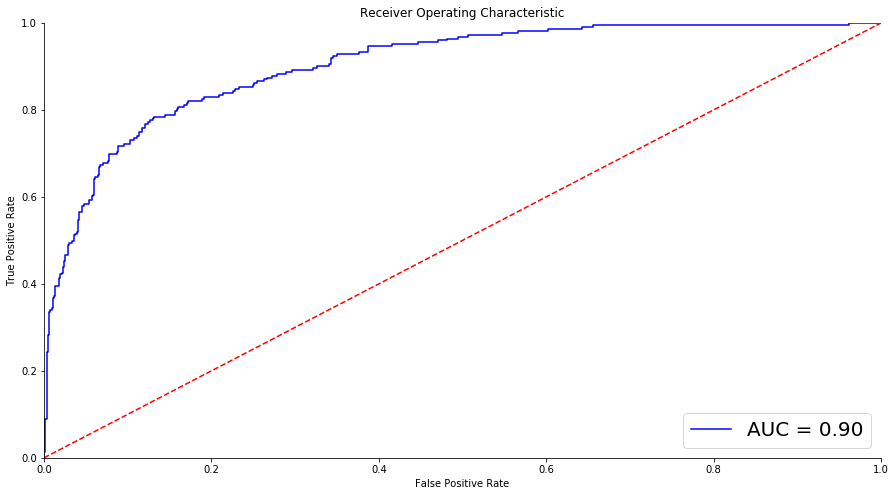

In [104]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr["micro"], tpr["micro"], 'b', label = 'AUC = %0.2f' % roc_auc["micro"])
plt.legend(loc = 'lower right', prop={'size': 20})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Arjona

In [109]:
drexler_df = pd.read_csv('data/drexler_complete_lyrics.csv', sep=';')
drexler_df = drexler_df[~drexler_df['duplicated']]
drexler_df = drexler_df.drop(['url', 'duplicated', 'album', 'year', 'id'], axis=1)
drexler_df['artist'] = 'Jorge Drexler'
arjona_df = pd.read_csv('data/arjona_raw_songs_v3.csv', sep=';')
arjona_df['artist'] = 'Ricardo Arjona'
df = pd.concat([drexler_df, arjona_df]).reset_index(drop=True)
print(df.shape)
df.head()

(361, 3)


,lyrics,title,artist
0,El perfume de la sal Del cabo Santa María Reco...,Bienvenida,Jorge Drexler
1,Nos delata el equipaje Y la duda al caminar Su...,Equipaje,Jorge Drexler
2,Se va la tarde en Zanja Honda La playa es brum...,La aparecida,Jorge Drexler
3,"Mabel, dejó El bolso con unas amigas Y salió a...",La luna de espejos,Jorge Drexler
4,Luna del Cabo Boca de túnel Lunar plateado Sob...,La luna del cabo,Jorge Drexler


In [110]:
df.tail()

,lyrics,title,artist
356,Letra de VivirVeo el sol resbalando en las par...,Vivir,Ricardo Arjona
357,Vivir sin ti es posible\nSin mayor dificultad\...,Vivir sin ti es posible,Ricardo Arjona
358,"Ella camina y pasa, yo me detengo y veo\nElla ...",Vuelo,Ricardo Arjona
359,Y ahora tu te me vas\nCansada de llorar\nQueri...,Y Ahora Tú Te Me Vas,Ricardo Arjona
360,"Ya no me acuerdo de mí, ya no me acuerdo de na...",Ya no Me Acuerdo de Mi,Ricardo Arjona


In [112]:
df.nunique()

lyrics    361
title     359
artist      2
dtype: int64

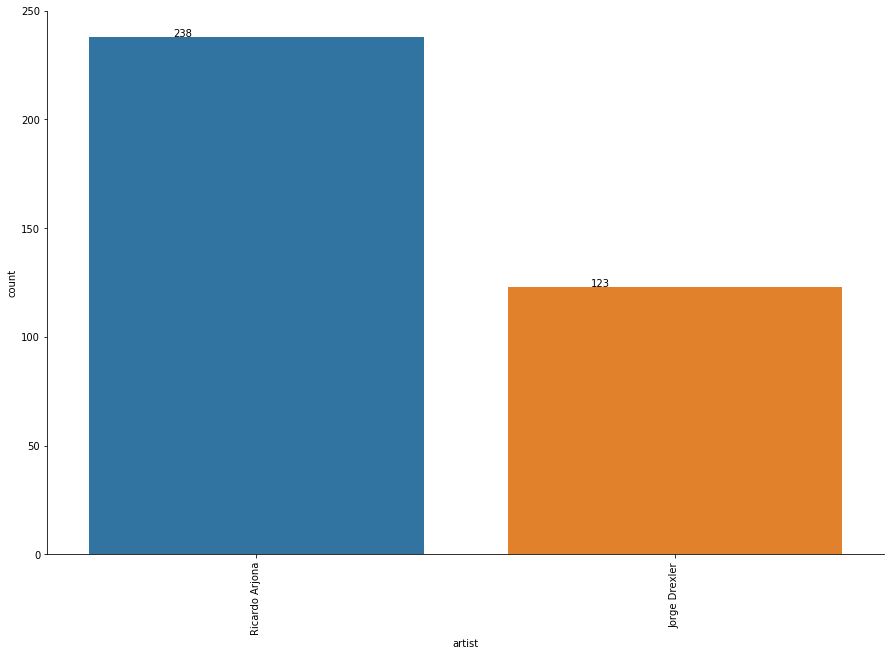

In [113]:
plot_artist_distribution(df)

In [118]:
df['artist_id'] = df['artist'].factorize()[0]
artist_id_df = df[['artist', 'artist_id']].drop_duplicates().sort_values('artist_id')
artist_to_id = dict(artist_id_df.values)
id_to_artist = dict(artist_id_df[['artist_id', 'artist']].values)
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(df.lyrics).toarray()
labels = df.artist_id
features.shape

(361, 33839)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['artist'], test_size=0.33, random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [
    RandomForestClassifier(class_weight='balanced'),
    LinearSVC(class_weight='balanced'),
    MultinomialNB(),
    LogisticRegression(class_weight='balanced',random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        print(fold_idx, accuracy)
    print("%s processed" % model_name)
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier
0 0.780821917808
1 0.794520547945
2 0.780821917808
3 0.830985915493
4 0.69014084507
RandomForestClassifier processed
LinearSVC
0 0.890410958904
1 0.849315068493
2 0.849315068493
3 0.830985915493
4 0.802816901408
LinearSVC processed
MultinomialNB
0 0.657534246575
1 0.657534246575
2 0.657534246575
3 0.661971830986
4 0.661971830986
MultinomialNB processed
LogisticRegression
0 0.917808219178
1 0.849315068493
2 0.849315068493
3 0.845070422535
4 0.830985915493
LogisticRegression processed


model_name
LinearSVC                 0.844569
LogisticRegression        0.858499
MultinomialNB             0.659309
RandomForestClassifier    0.775458
Name: accuracy, dtype: float64

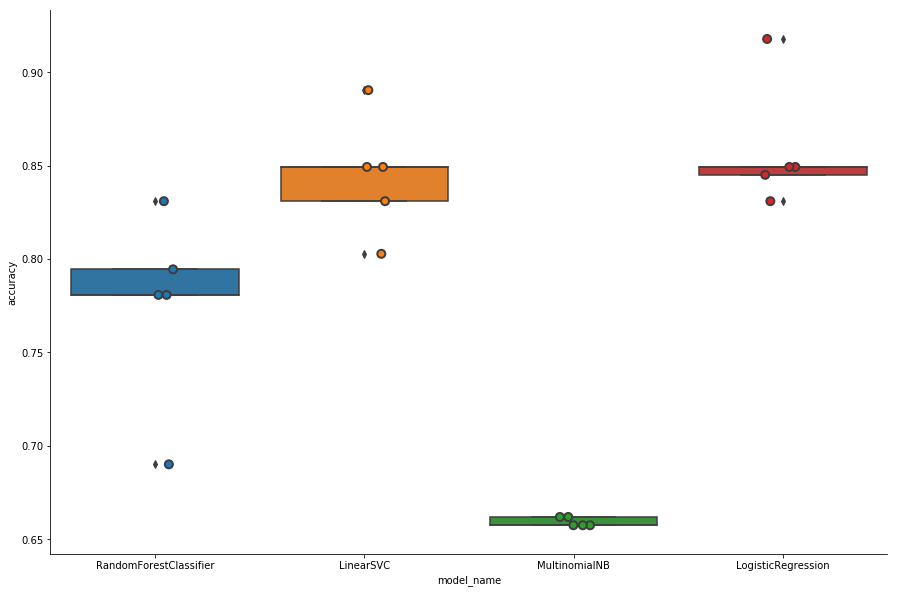

In [121]:
display(cv_df.groupby('model_name').accuracy.mean())
plt.figure(figsize=(15,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df);
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2);
sns.despine()
plt.show()

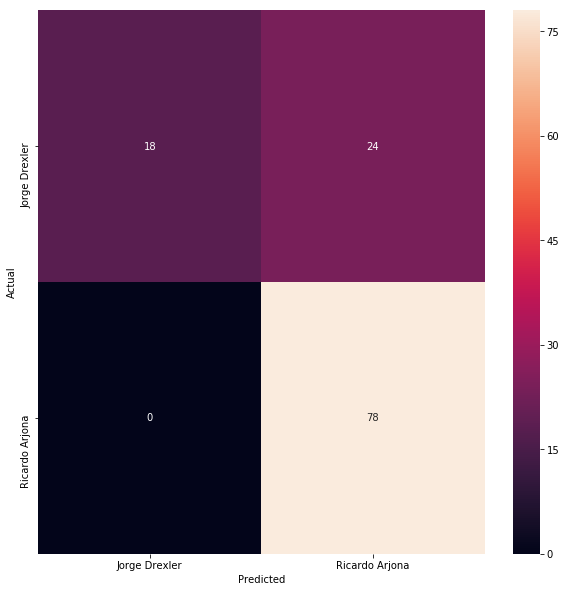

In [123]:
model = LogisticRegression(class_weight='balanced',random_state=0)


X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred, labels=labels.unique())
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=artist_id_df.artist.values, yticklabels=artist_id_df.artist.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [124]:
print(classification_report(y_test, y_pred, target_names=df['artist'].unique()))

                precision    recall  f1-score   support

 Jorge Drexler       1.00      0.43      0.60        42
Ricardo Arjona       0.76      1.00      0.87        78

   avg / total       0.85      0.80      0.77       120



In [125]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')
print("The precision of the Random Forest is %0.7f%%" % (precision * 100))
print("The recall of the Random Forest is %0.7f%%" % (recall * 100))
print("The fscore of the Random Forest is %0.7f%%" % (fscore * 100))
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1], pos_label=1) 
roc_auc = auc(fpr, tpr)

print("The area under the roc curve is worth of the Random Forest is %0.7f" % (roc_auc))

The precision of the Random Forest is 76.4705882%
The recall of the Random Forest is 100.0000000%
The fscore of the Random Forest is 86.6666667%
The area under the roc curve is worth of the Random Forest is 0.9838217


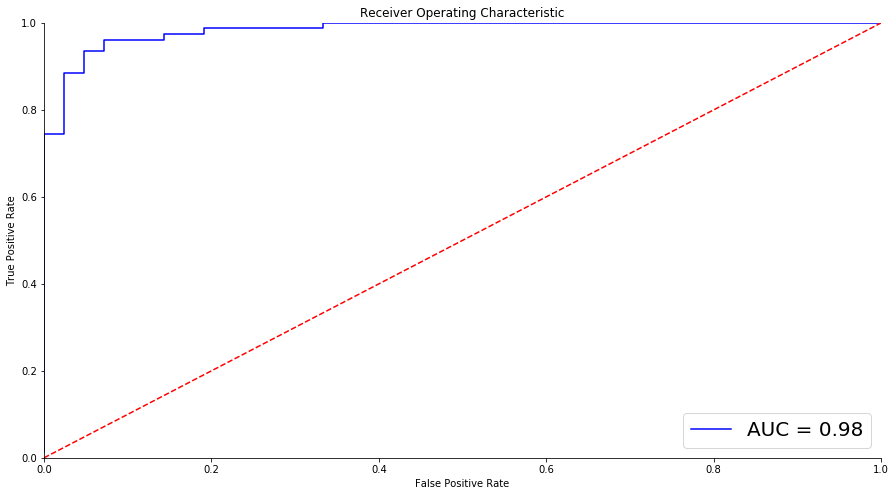

In [126]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', prop={'size': 20})
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()